### Financial Engineering 1: Hedging Assignment

In [12]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
# import data and print head to get rough idea of what is contained
data = pd.read_csv('./fe2.csv')
data.head()

,Unnamed: 0,Date,Underlying,C250,C255,C260,C265,C270,C275,C280,...,P400,P405,P410,P415,P420,P425,P430,P435,P440,P445
0,0,2023-08-21,321.88,77.91,NaN,67.65,NaN,55.00,54.39,49.6,...,77.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2023-08-22,322.46,77.60,NaN,69.55,NaN,NaN,54.27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2023-08-23,327.00,NaN,NaN,73.20,NaN,NaN,59.00,54.3,...,71.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2023-08-24,319.97,NaN,NaN,66.20,NaN,57.77,60.60,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2023-08-25,322.98,NaN,73.85,64.93,62.29,NaN,NaN,50.3,...,NaN,NaN,NaN,94.03,NaN,NaN,NaN,NaN,NaN,NaN


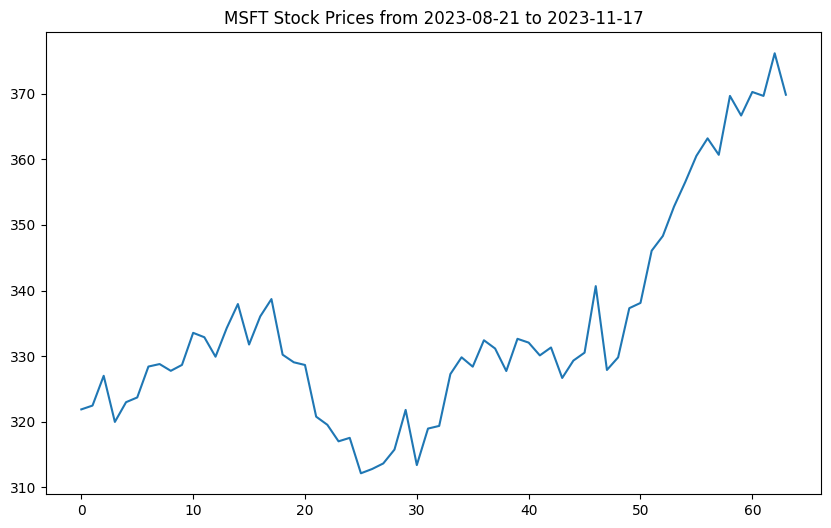

In [14]:
# display underlying stock prices in a chart
fig = plt.figure(figsize=(10,6))
plt.plot(data.index, data['Underlying'])
plt.title(f'MSFT Stock Prices from {data["Date"].min()} to {data["Date"].max()}')
plt.show()

In [15]:
# find dC, dP and dS
data_cols = [col for col in data.columns if col not in ['Unnamed: 0', 'Date']]
diff_data = data[data_cols].diff()
diff_data.columns = ['d_' + col for col in diff_data.columns]
data = pd.concat([data, diff_data], axis=1)
data.head()

,Unnamed: 0,Date,Underlying,C250,C255,C260,C265,C270,C275,C280,...,d_P400,d_P405,d_P410,d_P415,d_P420,d_P425,d_P430,d_P435,d_P440,d_P445
0,0,2023-08-21,321.88,77.91,NaN,67.65,NaN,55.00,54.39,49.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2023-08-22,322.46,77.60,NaN,69.55,NaN,NaN,54.27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2023-08-23,327.00,NaN,NaN,73.20,NaN,NaN,59.00,54.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2023-08-24,319.97,NaN,NaN,66.20,NaN,57.77,60.60,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2023-08-25,322.98,NaN,73.85,64.93,62.29,NaN,NaN,50.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# find dC/dS and dP/dS
for col in diff_data.columns:
    data[col + '_dS'] = data[col] / data['d_Underlying']
data.head()

,Unnamed: 0,Date,Underlying,C250,C255,C260,C265,C270,C275,C280,...,d_P400_dS,d_P405_dS,d_P410_dS,d_P415_dS,d_P420_dS,d_P425_dS,d_P430_dS,d_P435_dS,d_P440_dS,d_P445_dS
0,0,2023-08-21,321.88,77.91,NaN,67.65,NaN,55.00,54.39,49.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2023-08-22,322.46,77.60,NaN,69.55,NaN,NaN,54.27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2023-08-23,327.00,NaN,NaN,73.20,NaN,NaN,59.00,54.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2023-08-24,319.97,NaN,NaN,66.20,NaN,57.77,60.60,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2023-08-25,322.98,NaN,73.85,64.93,62.29,NaN,NaN,50.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# list of columns that contain delta values
call_delta_cols = [col for col in data.columns if col.endswith('_dS') and col.startswith('d_C')]
# start date for hedging, 45 days before last data point in dataframe
start_date = pd.to_datetime('2023-11-27') - pd.DateOffset(45)
#find the delta value that is closest to 0.5 on the start date, to get the ATM option
atm_call_delta_column_name = data[pd.to_datetime(data['Date']) == start_date][call_delta_cols].sub(0.5).abs().idxmin(axis=1).to_numpy()[0]
print(atm_call_delta_column_name)

d_C285_dS


In [18]:
call_column_name = atm_call_delta_column_name.split('_')[1]
portfolio_value = data[pd.to_datetime(data['Date']) == start_date][call_column_name].to_numpy()[0]
portfolio_delta = data[pd.to_datetime(data['Date']) == start_date][atm_call_delta_column_name].to_numpy()[0]
print(f'Portfolio Value: {portfolio_value}, Portfolio Delta: {portfolio_delta}')
replicating_portfolio_delta = -1*portfolio_delta
replicating_porfolio_value = replicating_portfolio_delta*data[pd.to_datetime(pd.to_datetime(data['Date'])) == start_date]['Underlying'].to_numpy()[0]
print(f'Current shares in replicating portfolio: 0')
print(f'Sell {portfolio_delta} shares to hedge portfolio')
print(f'Replicating Portfolio Value: {replicating_porfolio_value}, Replicating Portfolio Delta: {replicating_portfolio_delta}')
print(f'Total Portfolio Value: {portfolio_value + replicating_porfolio_value}, Total Portfolio Delta: {portfolio_delta + replicating_portfolio_delta}')

Portfolio Value: 46.8, Portfolio Delta: 0.5102040816326521
Current shares in replicating portfolio: 0
Sell 0.5102040816326521 shares to hedge portfolio
Replicating Portfolio Value: -167.20918367346908, Replicating Portfolio Delta: -0.5102040816326521
Total Portfolio Value: -120.40918367346909, Total Portfolio Delta: 0.0


In [19]:
next_day = start_date + pd.DateOffset(3)
portfolio_value = data[pd.to_datetime(data['Date']) == next_day][call_column_name].to_numpy()[0]
portfolio_delta = data[pd.to_datetime(data['Date']) == next_day][atm_call_delta_column_name].to_numpy()[0]
print(f'Portfolio Value: {portfolio_value}, Portfolio Delta: {portfolio_delta}')
replicating_portfolio_delta = -1*portfolio_delta
replicating_porfolio_value = replicating_portfolio_delta*data[pd.to_datetime(pd.to_datetime(data['Date'])) == next_day]['Underlying'].to_numpy()[0]
print(f'Current shares in replicating portfolio: 0.5102040816326521')
print(f'Sell {portfolio_delta - 0.5102040816326521} shares to hedge portfolio')
print(f'Replicating Portfolio Value: {replicating_porfolio_value}, Replicating Portfolio Delta: {replicating_portfolio_delta}')
print(f'Total Portfolio Value: {portfolio_value + replicating_porfolio_value}, Total Portfolio Delta: {portfolio_delta + replicating_portfolio_delta}')



Portfolio Value: 50.55, Portfolio Delta: 0.7637474541751577
Current shares in replicating portfolio: 0.5102040816326521
Sell 0.2535433725425056 shares to hedge portfolio
Replicating Portfolio Value: -254.05295315682443, Replicating Portfolio Delta: -0.7637474541751577
Total Portfolio Value: -203.50295315682445, Total Portfolio Delta: 0.0


In [20]:
def get_option_portfolio_values(portfolio, start_date, end_date, data):
    portfolio_values = []

    for index, row in data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].iterrows():
        value = 0
        for option, quantity, buy_sell in portfolio:
            if np.isnan(row[option]):
                raise ValueError('portfolio contains nan price')
            elif buy_sell == 'buy':
                value += row[option] * quantity
            else:
                value -= row[option] * quantity
        portfolio_values.append(value)

    return np.array(portfolio_values)

def get_values(ticker, start_date, end_date, data):
    return data[(data['Date'] >= start_date) & (data['Date'] <= end_date)][ticker].to_numpy()

def get_delta_values(portfolio, start_date, end_date, data):
    # delta values must be added to data frame first
    delta_values = []

    for index, row in data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].iterrows():
        value = 0
        for option, quantity, buy_sell in portfolio:
            if np.isnan(row['d_' + option + '_dS']):
                raise ValueError('portfolio contains nan delta value')
            elif buy_sell == 'buy':
                value += row['d_' + option + '_dS'] * quantity
            else:
                value -= row['d_' + option + '_dS'] * quantity
        delta_values.append(value)

    return np.array(delta_values)

def get_vega_values(portfolio, start_date, end_date, data):
    # vega values must be added to data frame first
    vega_values = []

    for index, row in data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].iterrows():
        value = 0
        for option, quantity, buy_sell in portfolio:
            if np.isnan(row['d_' + option + '_dk']):
                raise ValueError('portfolio contains nan vega value')
            elif buy_sell == 'buy':
                value += row['d_' + option + '_dk'] * quantity
            else:
                value -= row['d_' + option + '_dk'] * quantity
        vega_values.append(value)

    return np.array(vega_values)

def delta_hedge(hedging_frequency, portfolio_values, underlying_values, delta_values):
    if (any(np.isnan(delta_values)) or any(np.isnan(portfolio_values)) or any(np.isnan(underlying_values)) 
            or hedging_frequency <= 0 or hedging_frequency >= len(delta_values)):
        return False
    
    portfolio_value = portfolio_values[0]
    underlying_value = underlying_values[0]
    delta = delta_values[0]
    accuracies = []

    for i in range(hedging_frequency, len(delta_values), hedging_frequency):
        accuracy = (portfolio_values[i] - portfolio_value) - (underlying_values[i] - underlying_value) * delta
        accuracies.append(accuracy)
        portfolio_value = portfolio_values[i]
        underlying_value = underlying_values[i]
        delta = delta_values[i]

    mean_squared_error = sum([num**2 for num in accuracies]) / len(accuracies)

    return {
        'accuracies': accuracies,
        'mean_squered_error': mean_squared_error
    }

def option_portfolio_delta_hedging(portfolio, start_date, end_date, hedging_frequency, data):
    # portfolio example: [['C250', 2, 'buy'], ['P400', 1, 'sell']]

    portfolio_values = get_option_portfolio_values(portfolio, start_date, end_date, data)
    underlying_values = get_values('Underlying', start_date, end_date, data)
    delta_values = get_delta_values(portfolio, start_date, end_date, data)

    hedging_results = delta_hedge(hedging_frequency, portfolio_values, underlying_values, delta_values)
    return hedging_results

def solve_2_by_2_linear_system(equation_one, equation_two):
    # equations of the form ax + by = c, dx + ey = f
    a, b, c = equation_one
    d, e, f = equation_two

    x = (b * f - e * c) / (b * d - a * e)
    y = (c - a * x) / b

    return (x, y)

def delta_vega_hedge(hedging_frequency, portfolio_values, portfolio_delta_values, portfolio_vega_values, sec_one_values, sec_one_delta_values, 
                        sec_one_vega_values, sec_two_values, sec_two_delta_values, sec_two_vega_values):

    portfolio_value = portfolio_values[0]
    portfolio_delta= portfolio_delta_values[0]
    portfolio_vega = portfolio_vega_values[0]
    sec_one = sec_one_values[0]
    sec_one_delta = sec_one_delta_values[0]
    sec_one_vega = sec_one_vega_values[0]
    sec_two = sec_two_values[0]
    sec_two_delta = sec_two_delta_values[0]
    sec_two_vega = sec_two_vega_values[0]
    sec_one_amount, sec_two_amount = solve_2_by_2_linear_system([sec_one_delta, sec_two_delta, -portfolio_delta], 
                                                                    [sec_one_vega, sec_two_vega, -portfolio_vega])
    accuracies = []

    for i in range(hedging_frequency, len(sec_two_delta_values), hedging_frequency):
        change_in_portfolio = portfolio_values[i] - portfolio_value
        change_in_replication = sec_one_amount * (sec_one_values[i] - sec_one) + sec_two_amount * (sec_two_values[i] - sec_two)
        accuracy = change_in_portfolio - change_in_replication
        accuracies.append(accuracy)
        portfolio_value = portfolio_values[i]
        portfolio_delta= portfolio_delta_values[i]
        portfolio_vega = portfolio_vega_values[i]
        sec_one = sec_one_values[i]
        sec_one_delta = sec_one_delta_values[i]
        sec_one_vega = sec_one_vega_values[i]
        sec_two = sec_two_values[i]
        sec_two_delta = sec_two_delta_values[i]
        sec_two_vega = sec_two_vega_values[i]
        sec_one_amount, sec_two_amount = solve_2_by_2_linear_system([sec_one_delta, sec_two_delta, -portfolio_delta], 
                                                                        [sec_one_vega, sec_two_vega, -portfolio_vega])

    mean_squared_error = sum([num**2 for num in accuracies]) / len(accuracies)

    return {
        'accuracies': accuracies,
        'mean_squered_error': mean_squared_error
    }

def option_portfolio_delta_vega_hedging(portfolio, security_one, security_two, start_date, end_date, hedging_frequency, data):
    # portfolio example: [['C250', 2, 'buy'], ['P400', 1, 'sell']]

    portfolio_values = get_option_portfolio_values(portfolio, start_date, end_date, data)
    portfolio_delta_values = get_delta_values(portfolio, start_date, end_date, data)
    portfolio_vega_values = get_vega_values(portfolio, start_date, end_date, data)
    sec_one_values = get_values(security_one, start_date, end_date, data)
    sec_one_delta_values = get_delta_values([[security_one, 1, 'buy']], start_date, end_date, data)
    sec_one_vega_values = get_vega_values([[security_one, 1, 'buy']], start_date, end_date, data)
    sec_two_values = get_values(security_two, start_date, end_date, data)
    sec_two_delta_values = get_delta_values([[security_two, 1, 'buy']], start_date, end_date, data)
    sec_two_vega_values = get_vega_values([[security_two, 1, 'buy']], start_date, end_date, data)
    
    hedging_results = delta_vega_hedge(hedging_frequency, portfolio_values, portfolio_delta_values, portfolio_vega_values, sec_one_values, 
                                            sec_one_delta_values, sec_one_vega_values, sec_two_values, sec_two_delta_values, sec_two_vega_values)
    return hedging_results

In [21]:
results = option_portfolio_delta_hedging([['C300', 1, 'buy']], '2023-10-18', '2023-11-17', 1, data)
print(results)

{'accuracies': [0.4021538461538498, -0.7899173553718577, 0.1967741935483973, -0.6653962264150892, 6.084545454545411, -0.9558579881657021, -1.539342723004705, 6.456250000000005, 0.1946666666666551, -1.9999999999998366, -1.0371733668341747, 2.240755555555543, -1.2315401785713704, 3.368900804289517, -3.568500000000026, -1.3341573033707887, 2.119721115537822, 0.8333964365256077, 0.9685953177257765, -0.14671309192203708, -2.928333333333822, 2.3120923076923052], 'mean_squered_error': 6.401754731490487}


In [22]:
data.tail()[['Underlying', 'd_C370_dS', 'd_C365_dS', 'd_C320_dS']]

,Underlying,d_C370_dS,d_C365_dS,d_C320_dS
59,366.68,0.612040,0.866221,0.983278
60,370.27,0.289694,0.576602,1.125348
61,369.67,1.183333,1.166667,1.233333
62,376.17,0.598462,0.801538,0.876923
63,369.85,0.977848,0.927215,1.120253
